# Neural Network Modelling for Glacier Mass Balance Prediction

This notebook implements **neural network models** for predicting glacier point mass balance measurements using meteorological and topographical features. The notebook supports two main modelling approaches:

##  **Modelling Strategies**

### 1. **Regional Modelling (French Alps Only)**
- Train and test exclusively on French Alps glacier data
- Uses glacier-based train/test splits to ensure spatial generalization

### 2. **Cross-Regional Modelling (Switzerland → French Alps)**
- Combines data from Swiss glaciers and French Alps glaciers
- Can be used as either a cross-regional model, training exclusively on Swiss data and testing on French Alps data
- or as a baseline for transfer learning models, training on Swiss data and a subset of Icelandic data and testing on remaining Icelandic data

---

##  **Prerequisites**
- French Alps glacier dataset from `../1.1. France-prepro.ipynb`
- Swiss glacier dataset from `regions/Switzerland/1.1. GLAMOS-prepro.ipynb`
- ERA5 climate data for both regions from `../1.2. ERA5Land-prepro.ipynb`
---

### Feature Definitions

**Climate Features (ERA5 Reanalysis):**
- `t2m`: 2-meter temperature
- `tp`: Total precipitation
- `slhf`/`sshf`: Surface heat fluxes
- `ssrd`: Surface solar radiation downwards
- `fal`: Albedo
- `str`: Surface net thermal radiation
- `u10`/`v10`: Wind components

**Topographical Features (OGGM):**
- `aspect`/`slope`: Terrain geometry
- `hugonnet_dhdt`: Ice thickness changes
- `consensus_ice_thickness`: Ice depth
- `millan_v`: Ice surface velocity
- `elevation_difference`: Measurement elevation − ERA5-Land grid cell elevation

In [ ]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import numpy as np
import warnings
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import massbalancemachine as mbm
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle 
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from scripts.helpers import *
from scripts.glacioclim_preprocess import *
from scripts.plots import *
from scripts.config_FR import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.FranceConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/')

## Environment Setup & Configuration

In [2]:
# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

In [3]:
seed_all(cfg.seed)

if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()
else:
    print("CUDA is NOT available")


CUDA is available


## A. Regional Modelling (French Alps Only)

This approach trains neural networks exclusively on French Alps glacier data.

## Data Loading & Initial Processing

### Create French Alps Glacier Dataset

Start with point mass balance measurements and transform them to monthly format with ERA5 climate data.

In [4]:
data_glacioclim = pd.read_csv(cfg.dataPath + path_PMB_GLACIOCLIM_csv + 'FR_wgms_dataset_all_oggm_with_blanc.csv')

print('Number of glaciers:', len(data_glacioclim['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_glacioclim[data_glacioclim.PERIOD == 'annual']) + len(data_glacioclim[data_glacioclim.PERIOD == 'winter']) + len(data_glacioclim[data_glacioclim.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'winter']))
#print('Number of summer samples:',
      #len(data_glacioclim[data_glacioclim.PERIOD == 'summer']))

data_glacioclim = data_glacioclim[data_glacioclim['PERIOD'] != 'summer']

data_glacioclim.columns


Number of glaciers: 9
Number of winter, summer and annual samples: 10762
Number of annual samples: 4785
Number of winter samples: 3281


Index(['POINT_ID', 'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE',
       'TO_DATE', 'POINT_BALANCE', 'GLACIER', 'PERIOD', 'GLACIER_ZONE', 'YEAR',
       'DATA_MODIFICATION', 'RGIId', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v'],
      dtype='object')

### Dataset Transformation to Monthly Format

Transform point mass balance data to monthly resolution and integrate with ERA5 climate variables.

In [5]:
data_glacioclim_test = data_glacioclim.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_GLACIOCLIM_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_Alps.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_Alps.nc'
}

RUN = False
dataloader_gl = process_or_load_data_glacioclim(run_flag=RUN,
                                     df=data_glacioclim_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file = 'FR_wgms_dataset_monthly_full_no_summer_with_blanc.csv')
data_monthly = dataloader_gl.data

2025-10-15 15:35:56,656 - INFO - Loaded preprocessed data.
2025-10-15 15:35:56,657 - INFO - Number of monthly rows: 81534
2025-10-15 15:35:56,669 - INFO - Number of annual samples: 57592
2025-10-15 15:35:56,676 - INFO - Number of winter samples: 23942


### Train/Test Splitting Strategy

**Spatial Generalization Approach:** Select test set based on glaciers, remaining glaciers will be the train set

In [ ]:
test_glaciers = ['FR4N01146D09+E06 Gebroulaz']

#test_glaciers = ['FR4N01083B21 Blanc']

# Regional 50%
#test_glaciers = ['FR4N01236A07 de Talefre','FR4N01235A08 dArgentiere', 'FR4N01146D09+E06 Gebroulaz']

# 5-10% or 653 IDs in training set
#test_glaciers = ['FR4N01235A08 dArgentiere' ,'FR4N01146D09+E06 Gebroulaz' ,'FR4N01236A01 Mer de Glace/Geant','FR4N01162B09+154D03 de Saint Sorlin', 'FR4N01083B21 Blanc']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Size of test data: 12495
Size of train data: 69039
Percentage of test size: 18.10%
Train glaciers: (8) ['FR4N01235A08 dArgentiere' 'FR4N01083B21 Blanc'
 'FR4N01236A01 Mer de Glace/Geant' 'FR4N01236A01 Leschaux'
 'FR4N01236A07 de Talefre' 'FR4N01163A02 de Sarennes 1'
 'FR4N01162B09+154D03 de Saint Sorlin' 'FR4N01236A02 des Grands Montets']
Test glaciers: (1) ['FR4N01146D09+E06 Gebroulaz']


**Temporal Generalization Approach:** Withhold X of the last years for the testing set.

In [6]:
test_years_count = 10

all_years = sorted(dataloader_gl.data['YEAR'].unique())

# Use the most recent years as test data
train_years = all_years[:-test_years_count]
test_years = all_years[-test_years_count:]

# Statistics prints
print('Size of test data:', len(test_years))
data_train = dataloader_gl.data[dataloader_gl.data.YEAR.isin(
    train_years)]
print('Size of train data:', len(train_years))
if len(train_years) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(test_years) / len(train_years)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(
                                dataloader_gl,
                                test_split_on='YEAR',
                                test_splits=test_years,
                                random_state=cfg.seed)



print('Train year: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test years: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

region_name='Prediction most recent 10 years'

Size of test data: 10
Size of train data: 58
Percentage of test size: 17.24%
Train year: (58) [2006 2007 2008 2009 2010 2011 2012 2013 2014 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 1993 1976 1977 1978 1979 1980 1981
 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1957 1958 1959
 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975]
Test years: (10) [2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


### Training/Validation Split Strategy (80/20)

**Standard Approach:** Random 80/20 split across all available training data.

In [ ]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

## B. Cross-Regional Transfer Learning (Switzerland → French Alps)

This approach uses the Swiss dataset to try and model French Alps glaciers.

### Create Combined Swiss and French Alps Glacier Dataset

Start with point mass balance measurements and transform them to monthly format with ERA5 climate data.

In [20]:
# Read in
data_FR = pd.read_csv(cfg.dataPath + path_PMB_GLACIOCLIM_csv + 'FR_wgms_dataset_all_oggm_with_blanc.csv')
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
# Adjust dfs to match
data_CH['GLACIER_ZONE'] = 'Placeholder'
data_CH['DATA_MODIFICATION'] = ''
data_CH = data_CH.drop(columns=['aspect_sgi', 'slope_sgi', 'topo_sgi'], errors='ignore')

data_FR = data_FR[data_FR['PERIOD'] != 'summer']

# Merge FR with CH
data_FR_CH = pd.concat([data_FR, data_CH], axis=0).reset_index(drop=True)

display(len(data_FR_CH['GLACIER'].unique()))

48

In [21]:
# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_GLACIOCLIM_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_Alps.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_Alps.nc'
}

RUN = False
dataloader_gl = process_or_load_data_glacioclim(run_flag=RUN,
                                     df=data_FR_CH,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'FR_CH_wgms_dataset_monthly_full_with_blanc.csv')
data_monthly_FR_CH = dataloader_gl.data

display(data_monthly_FR_CH.head(2))

2025-09-29 12:48:55,748 - INFO - Loaded preprocessed data.
2025-09-29 12:48:55,750 - INFO - Number of monthly rows: 372216
2025-09-29 12:48:55,809 - INFO - Number of annual samples: 145032
2025-09-29 12:48:55,845 - INFO - Number of winter samples: 227184


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,2006,7.024819,45.944607,-0.67,2524.444781,509.075219,3033.52,RGI60-11.03638,Argentiere_Tour_Noir_annual_smb_abl_2006_Tour ...,0,...,5.479116,1.863434,0.002194,-1039166.0,-437704.0,10756431.0,0.497862,-3961346.0,-0.321241,0.331826
1,2006,7.024819,45.944607,-0.67,2524.444781,509.075219,3033.52,RGI60-11.03638,Argentiere_Tour_Noir_annual_smb_abl_2006_Tour ...,0,...,5.479116,-5.253510,0.001675,-277848.0,-212654.0,7246084.0,0.564720,-3621156.0,-0.175529,0.153369


### Train/Test Splitting Strategy

**Spatial Generalization Approach:** Select test set based on glaciers, remaining glaciers will be the train set

In [ ]:
#test_glaciers = list(data_FR['GLACIER'].unique())

# 5-10% or 653 IDs in train set
test_glaciers = ['FR4N01235A08 dArgentiere' ,'FR4N01146D09+E06 Gebroulaz' ,'FR4N01236A01 Mer de Glace/Geant','FR4N01162B09+154D03 de Saint Sorlin', 'FR4N01083B21 Blanc']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = list(data_CH['GLACIER'].unique())
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

### Training/Validation Split Strategy (80/20)

**Standard Approach:** Random 80/20 split across all available training data (Swiss + French Alps training glaciers).

In [23]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

### Training/Validation Split - Target Domain Focus (80/20)

**Domain-Aware Approach:** This split will only build the validation set from French data

- **Training Set:** All Swiss data + 80% of French Alps training glaciers
- **Validation Set:** 20% of French Alps training glaciers only

This ensures that the same validation set is used as in fine-tuning and layer freezing in the `../3.2.4 Train-ML-model-NN_progressive_transfer` Notebook.

In [ ]:
# Full training pool = CH + France subset
data_train = train_set['df_X'].copy()
data_train['y'] = train_set['y']

# France train_glaciers
france_train_glacier = [
    g for g in data_FR['GLACIER'].unique()
    if g not in test_glaciers
]
display('train glaciers from target domain: ', france_train_glacier)

# Find France subset within this pool
france_mask = data_train['GLACIER'].isin(france_train_glacier)
data_france = data_train.loc[france_mask]

# Split only the France subset
dataloader = mbm.dataloader.DataLoader(cfg, data=data_france)
train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

france_train_idx = list(train_itr)
france_val_idx = list(val_itr)

# Training set = CH + France train portion
df_X_train = pd.concat([
    data_train.loc[~france_mask],                           # all CH glaciers
    data_france.iloc[france_train_idx]                    # France train glaciers
])
y_train = df_X_train['POINT_BALANCE'].values

# Validation set = France val portion only
df_X_val = data_france.iloc[france_val_idx]
y_val = df_X_val['POINT_BALANCE'].values


print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

## Neural Network Configuration & Training

Implementing a **Multilayer perceptron deep neural network** designed specifically for glacier mass balance prediction

The following cell is optional and initializes a period_indicator variable, which allows the NN to keep track if the current point is from a winter or annual measurement.

Uncomment `#+ ['PERIOD_INDICATOR']` in the "Define features" cell if you want to use this feature.

In [ ]:
## Optional, don't run if you dont want to use period_indicator

def create_period_indicator(df):
    """Create numerical PERIOD_INDICATOR feature"""
    df = df.copy()
    df['PERIOD_INDICATOR'] = df['PERIOD'].map({'annual': 0, 'winter': 1})
    return df

# Apply to all datasets
df_X_train = create_period_indicator(df_X_train)
df_X_val = create_period_indicator(df_X_val)
test_set['df_X'] = create_period_indicator(test_set['df_X'])

print("PERIOD_INDICATOR created:")
print("Annual (0):", (df_X_train['PERIOD_INDICATOR'] == 0).sum())
print("Winter (1):", (df_X_train['PERIOD_INDICATOR'] == 1).sum())
print("Original PERIOD column preserved:", df_X_train['PERIOD'].unique())

PERIOD_INDICATOR created:
Annual (0): 70474
Winter (1): 162220
Original PERIOD column preserved: ['annual' 'winter']


Define features

In [ ]:
features_topo = [
    'ELEVATION_DIFFERENCE',
] + list(vois_topographical)

feature_columns = features_topo + list(vois_climate) # + ['PERIOD_INDICATOR']

cfg.setFeatures(feature_columns)

all_columns = feature_columns + cfg.fieldsNotFeatures

df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of validation dataset:', df_X_val_subset.shape)
print('Shape of testing dataset:', df_X_test_subset.shape)
print('Running with features:', feature_columns)

assert all(train_set['df_X'].POINT_BALANCE == train_set['y'])

Shape of training dataset: (55273, 28)
Shape of validation dataset: (13766, 28)
Shape of testing dataset: (12495, 28)
Running with features: ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10']


### Network Initialization & Hyperparameters

**NN Configuration:**
- **Learning Rate:** 0.001 with ReduceLROnPlateau scheduling
- **Batch Size:** 128 samples per gradient update  
- **Optimization:** Adam optimizer with L2 weight decay (1e-5)
- **Architecture:** [128, 128, 64, 32] hidden layers with 20% dropout
- **Regularization:** Batch normalization + early stopping (patience=15)

**Callbacks for Robust Training:**
- **Early Stopping:** Prevents overfitting by monitoring validation loss
- **Learning Rate Scheduler:** Reduces LR when validation loss plateaus

In [ ]:
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=1e-4,  # Optional: stop only when improvement is very small
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              monitor='valid_loss',
                              mode='min',
                              factor=0.5,
                              patience=5,
                              threshold=0.01,
                              threshold_mode='rel',
                              verbose=True)

dataset = dataset_val = None  # Initialized hereafter


def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val


# param_init = {'device': 'cuda:0'}
param_init = {'device': 'cpu'}  # Use CPU for training
nInp = len(feature_columns)

params = {
    'lr': 0.001,
    'batch_size': 128,
    'optimizer': torch.optim.Adam,
    'optimizer__weight_decay': 1e-05,
    'module__hidden_layers': [128, 128, 64, 32],
    'module__dropout': 0.2,
    'module__use_batchnorm': True,
}

args = {
    'module': FlexibleNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params['module__dropout'],
    'module__hidden_layers': params['module__hidden_layers'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 200,
    'optimizer': params['optimizer'],
    'optimizer__weight_decay': params['optimizer__weight_decay'],
    'module__use_batchnorm': params['module__use_batchnorm'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}
custom_nn = mbm.models.CustomNeuralNetRegressor(cfg, **args, **param_init)

### Dataset Preparation for Neural Network Training

In [25]:
features, metadata = custom_nn._create_features_metadata(df_X_train_subset)

features_val, metadata_val = custom_nn._create_features_metadata(
    df_X_val_subset)

# Define the dataset for the NN
dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                features=features,
                                                metadata=metadata,
                                                targets=y_train)
dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                  SliceDataset(dataset, idx=1))
print("train:", dataset.X.shape, dataset.y.shape)

dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features_val,
                                                    metadata=metadata_val,
                                                    targets=y_val)
dataset_val = mbm.data_processing.SliceDatasetBinding(
    SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
print("validation:", dataset_val.X.shape, dataset_val.y.shape)

train: (5424,) (5424,)
validation: (1357,) (1357,)


### Model Training & Checkpointing

Set `TRAIN = True` to train new model.

Training the model...
Model parameters:
module: <class 'scripts.NN_networks.FlexibleNetwork'>
nbFeatures: 15
module__input_dim: 15
module__dropout: 0.2
module__hidden_layers: [128, 128, 64, 32]
train_split: <function my_train_split at 0x71130f3254e0>
batch_size: 128
verbose: 1
iterator_train__shuffle: True
lr: 0.001
max_epochs: 200
optimizer: <class 'torch.optim.adam.Adam'>
optimizer__weight_decay: 1e-05
module__use_batchnorm: True
callbacks: [('early_stop', <skorch.callbacks.training.EarlyStopping object at 0x71130f307490>), ('lr_scheduler', <skorch.callbacks.lr_scheduler.LRScheduler object at 0x71130f317550>)]
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1        2.2482        0.7987  0.0010  6.7546
      2        1.3153        0.5869  0.0010  6.8286
      3        1.1542        0.5242  0.0010  4.3861
      4        1.0705        0.5725  0.0010  6.7083
      5        0.9751        0.5184  0.0010  4.8623
      6        0

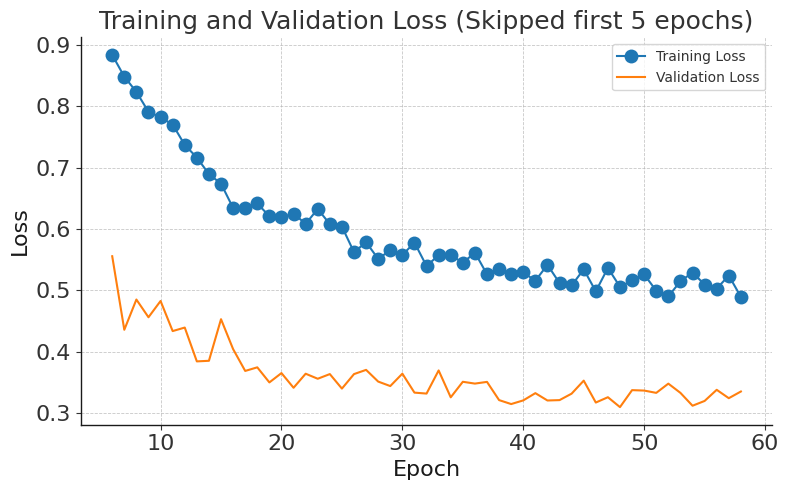

In [ ]:
TRAIN = True
if TRAIN:
    custom_nn.seed_all()

    print("Training the model...")
    print('Model parameters:')
    for key, value in args.items():
        print(f"{key}: {value}")
    custom_nn.fit(dataset.X, dataset.y)
    # The dataset provided in fit is not used as the datasets are overwritten in the provided train_split function

    # Generate filename with current date
    current_date = datetime.now().strftime("%Y-%m-%d")
    model_filename = f"nn_model_{current_date}"

    plot_training_history(custom_nn, skip_first_n=5)

    # After Training: Best weights are already loaded
    # Save the model
    custom_nn.save_model(model_filename)
    
    # save params dic
    params_filename = f"nn_params_{current_date}.pkl"

    with open(f"models/{params_filename}", "wb") as f:
        pickle.dump(args, f)

Load previously trained model.

In [ ]:

# Load model and set to CPU
model_filename = "nn_model_2025-09-30.pt"

loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
    cfg,
    model_filename,
    **{
        **args,
        **param_init
    },
)
loaded_model = loaded_model.set_params(device='cpu')
loaded_model = loaded_model.to('cpu')

### Model Evaluation & Prediction Analysis

In [28]:
# Create features and metadata
features_test, metadata_test = loaded_model._create_features_metadata(
    df_X_test_subset)

# Ensure all tensors are on CPU if they are torch tensors
if hasattr(features_test, 'cpu'):
    features_test = features_test.cpu()

# Ensure targets are also on CPU
targets_test = test_set['y']
if hasattr(targets_test, 'cpu'):
    targets_test = targets_test.cpu()

# Create the dataset
dataset_test = mbm.data_processing.AggregatedDataset(cfg,
                                                     features=features_test,
                                                     metadata=metadata_test,
                                                     targets=targets_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),
    SliceDataset(dataset_test, idx=1)
]

# Make predictions aggr to meas ID
y_pred = loaded_model.predict(dataset_test[0])
y_pred_agg = loaded_model.aggrPredict(dataset_test[0])

batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate scores
score = loaded_model.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson = loaded_model.evalMetrics(y_pred, y_true)

# Aggregate predictions
id = dataset_test[0].dataset.indexToId(batchIndex)
data = {
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
}
grouped_ids = pd.DataFrame(data)

# Add period
periods_per_ids = df_X_test_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID')

# Add glacier name
glacier_per_ids = df_X_test_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glacier_per_ids, on='ID')

# Add YEAR
years_per_ids = df_X_test_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID')

Save results

In [ ]:
# Save individual grouped_ids as CSV
split_name = "cross_regional_asdfasdf"
csv_filename = f"grouped_ids_{split_name.replace('%', 'pct').replace('-', '_')}.csv"
grouped_ids.to_csv(f"results/{csv_filename}", index=False)

split_name = "cross_regional_all_FR_CH_periodindicator"  
csv_filename = f"results/grouped_ids_{split_name}.csv"

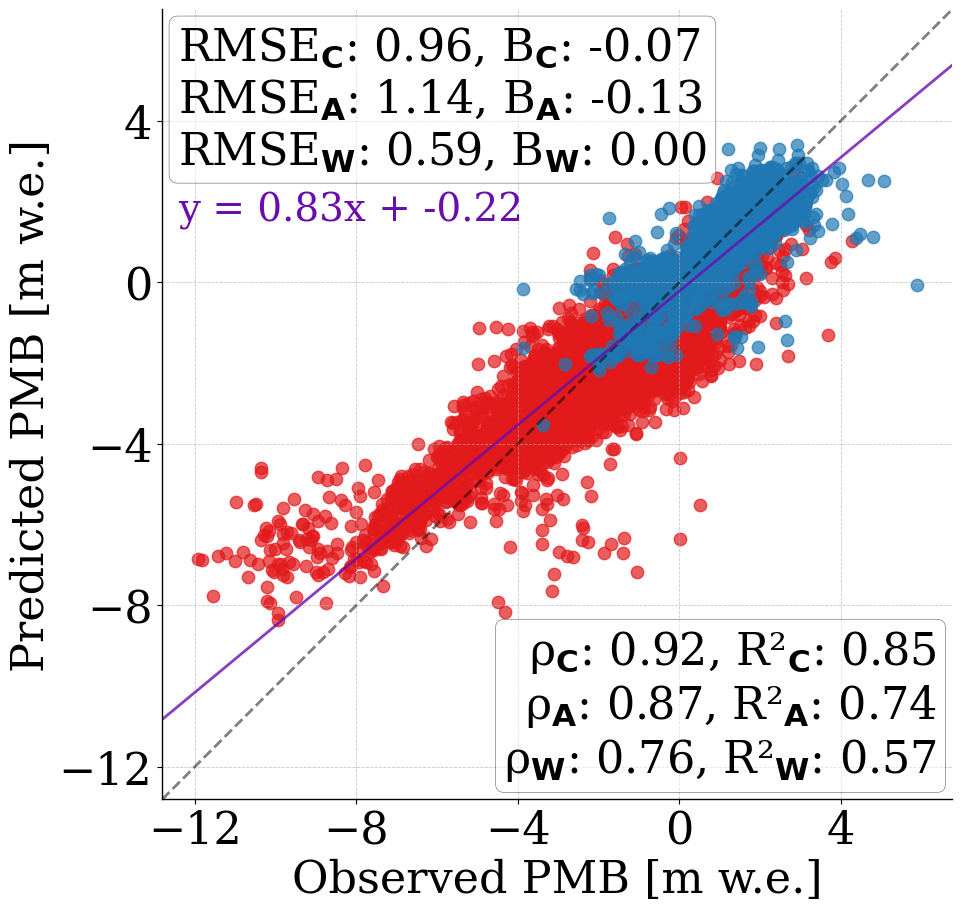

In [26]:
PlotPredictionsCombined_NN_additional(grouped_ids, region_name='Blanc', nticks=6, min_val=-11.92, max_val=5.88)

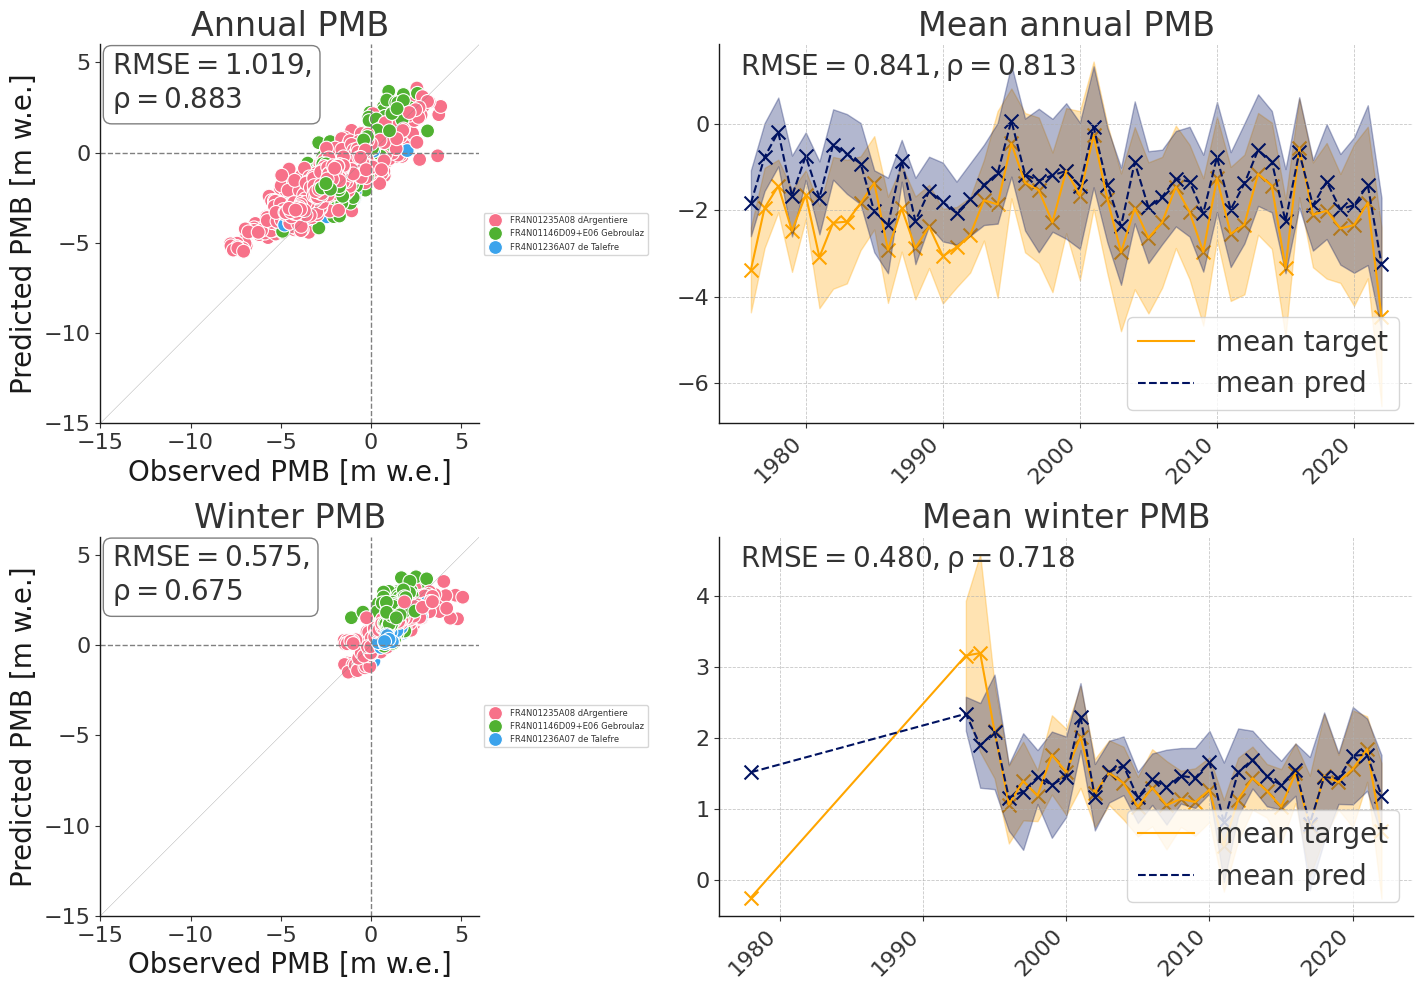

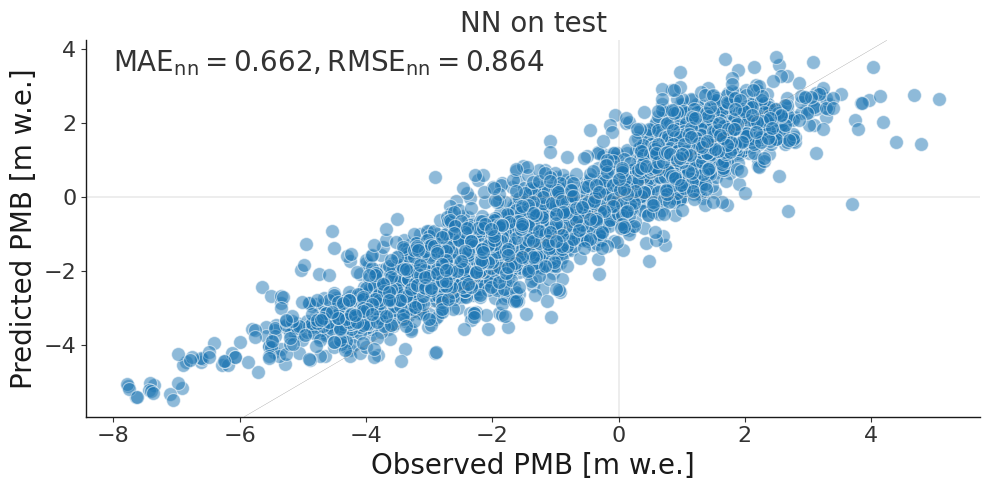

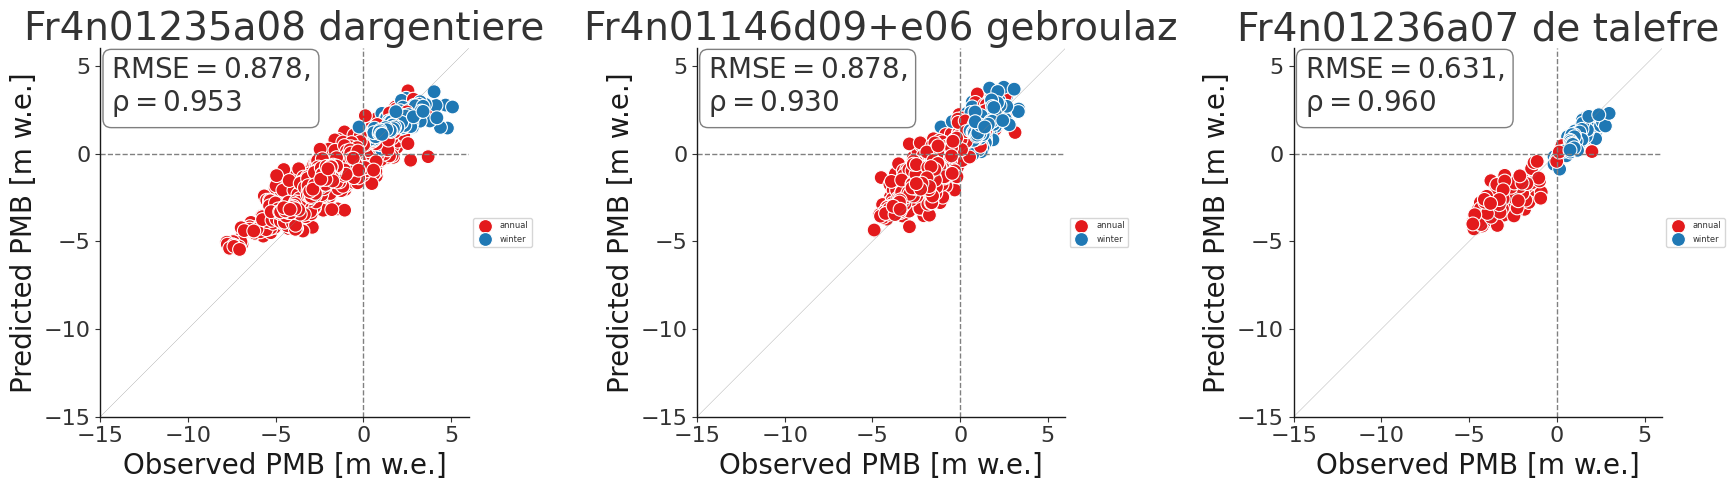

In [ ]:
PlotPredictions_NN(grouped_ids)
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))